In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

cuda


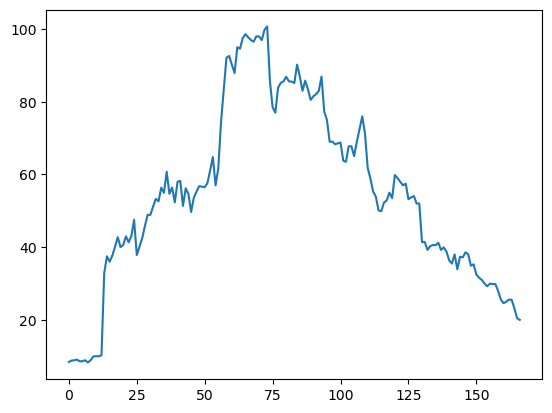

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
 
df = pd.read_csv('./data/AAMC 과거 데이터.csv')[['종가']].values.astype('float32')
 
plt.plot(df)
plt.show()

In [44]:
import torch
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [64]:
len(df)

167

In [65]:
lookback = 7
# train-test split for time series
train_size = int(len(df) * 0.67)
test_size = len(df) - train_size
train, test = df[:train_size], df[train_size:]
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([104, 7, 1]) torch.Size([104, 7, 1])
torch.Size([49, 7, 1]) torch.Size([49, 7, 1])


In [66]:
import torch.nn as nn
 
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [67]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = Model()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 67.7124, test RMSE 41.6657
Epoch 100: train RMSE 23.1726, test RMSE 7.4018
Epoch 200: train RMSE 9.8918, test RMSE 7.7229
Epoch 300: train RMSE 6.3774, test RMSE 6.8311
Epoch 400: train RMSE 5.0266, test RMSE 7.0308
Epoch 500: train RMSE 4.3244, test RMSE 7.4222
Epoch 600: train RMSE 3.8170, test RMSE 7.0246
Epoch 700: train RMSE 3.7960, test RMSE 7.7019
Epoch 800: train RMSE 3.4078, test RMSE 7.1974
Epoch 900: train RMSE 3.3569, test RMSE 7.0699
Epoch 1000: train RMSE 3.3096, test RMSE 7.0176
Epoch 1100: train RMSE 3.2348, test RMSE 6.9948
Epoch 1200: train RMSE 3.1841, test RMSE 6.7507
Epoch 1300: train RMSE 3.1468, test RMSE 6.9342
Epoch 1400: train RMSE 3.0889, test RMSE 6.9354
Epoch 1500: train RMSE 3.1367, test RMSE 6.8592
Epoch 1600: train RMSE 3.0546, test RMSE 7.0373
Epoch 1700: train RMSE 3.0380, test RMSE 7.0243
Epoch 1800: train RMSE 3.0251, test RMSE 6.8190
Epoch 1900: train RMSE 2.9876, test RMSE 6.7921


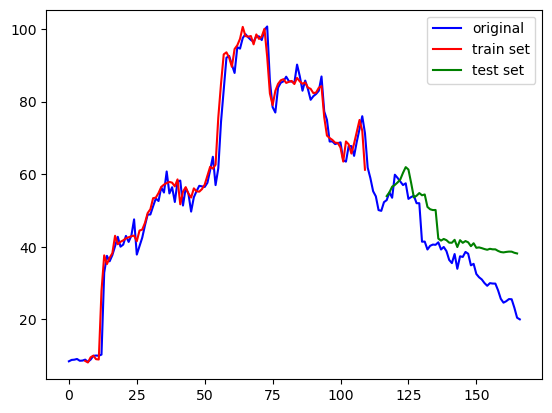

In [77]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(df) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(df) * np.nan
    test_plot[train_size+lookback:len(df)] = model(X_test)[:, -1, :]
# plot
plt.plot(df, c='b', label='original')
plt.plot(train_plot[1:], c='r', label='train set')
plt.plot(test_plot[1:], c='g', label='test set')
plt.legend()
plt.show()